In [ ]:
!pip install torch==2.2.1

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
!pip install gymnasium
!pip install gymnasium[classic-control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.7 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F


In [ ]:

# Define model
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, out_actions):
        super().__init__()

        # Define network layers
        self.fc1 = nn.Linear(in_states, h1_nodes)   # first fully connected layer
        self.out = nn.Linear(h1_nodes, out_actions) # ouptut layer w

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Apply rectified linear unit (ReLU) activation
        x = self.out(x)         # Calculate output
        return x

# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

# MountainCar Deep Q-Learning
class MountainCarDQL():
    # Hyperparameters (adjustable)
    learning_rate_a = 0.01         # learning rate (alpha)
    discount_factor_g = 0.9         # discount rate (gamma)
    network_sync_rate = 50000          # number of steps the agent takes before syncing the policy and target network
    replay_memory_size = 100000       # size of replay memory
    mini_batch_size = 32            # size of the training data set sampled from the replay memory

    num_divisions = 20

    # Neural Network
    loss_fn = nn.MSELoss()          # NN Loss function. MSE=Mean Squared Error can be swapped to something else.
    optimizer = None                # NN Optimizer. Initialize later.


    # Train the environment
    def train(self, episodes, render=False):
        # Create FrozenLake instance
        env = gym.make('MountainCar-v0', render_mode='human' if render else None)
        num_states = env.observation_space.shape[0] # expecting 2: position & velocity
        num_actions = env.action_space.n

        # Divide position and velocity into segments
        self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07

        epsilon = 1 # 1 = 100% random actions
        memory = ReplayMemory(self.replay_memory_size)

        # Create policy and target network. Number of nodes in the hidden layer can be adjusted.
        policy_dqn = DQN(in_states=num_states, h1_nodes=10, out_actions=num_actions)
        target_dqn = DQN(in_states=num_states, h1_nodes=10, out_actions=num_actions)

        # Make the target and policy networks the same (copy weights/biases from one network to the other)
        target_dqn.load_state_dict(policy_dqn.state_dict())

        # Policy network optimizer. "Adam" optimizer can be swapped to something else.
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        # List to keep track of rewards collected per episode. Initialize list to 0's.
        rewards_per_episode = []

        # List to keep track of epsilon decay
        epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        step_count=0
        goal_reached=False
        best_rewards=-200

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal

            rewards = 0

            # Agent navigates map until it falls into hole/reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and rewards>-1000):

                # Select action based on epsilon-greedy
                if random.random() < epsilon:
                    # select random action
                    action = env.action_space.sample() # actions: 0=left,1=idle,2=right
                else:
                    # select best action
                    with torch.no_grad():
                        action = policy_dqn(self.state_to_dqn_input(state)).argmax().item()

                # Execute action
                new_state,reward,terminated,truncated,_ = env.step(action)

                # Accumulate reward
                rewards += reward

                # Save experience into memory
                memory.append((state, action, new_state, reward, terminated))

                # Move to the next state
                state = new_state

                # Increment step counter
                step_count+=1

            # Keep track of the rewards collected per episode.
            rewards_per_episode.append(rewards)
            if(terminated):
                goal_reached = True

            # Graph training progress
            if(i!=0 and i%1000==0):
                print(f'Episode {i} Epsilon {epsilon}')

                self.plot_progress(rewards_per_episode, epsilon_history)

            if rewards>best_rewards:
                best_rewards = rewards
                print(f'Best rewards so far: {best_rewards}')
                # Save policy
                torch.save(policy_dqn.state_dict(), f"mountaincar_dql_{i}.pt")

            # Check if enough experience has been collected
            if len(memory)>self.mini_batch_size and goal_reached:
                mini_batch = memory.sample(self.mini_batch_size)
                self.optimize(mini_batch, policy_dqn, target_dqn)

                # Decay epsilon
                epsilon = max(epsilon - 1/episodes, 0)
                epsilon_history.append(epsilon)

                # Copy policy network to target network after a certain number of steps
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count=0

        # Close environment
        env.close()
    def plot_progress(self, rewards_per_episode, epsilon_history):
        # Create new graph
        plt.figure(1)

        # Plot average rewards (Y-axis) vs episodes (X-axis)
        # rewards_curve = np.zeros(len(rewards_per_episode))
        # for x in range(len(rewards_per_episode)):
            # rewards_curve[x] = np.min(rewards_per_episode[max(0, x-10):(x+1)])
        plt.subplot(121) # plot on a 1 row x 2 col grid, at cell 1
        # plt.plot(sum_rewards)
        plt.plot(rewards_per_episode)

        # Plot epsilon decay (Y-axis) vs episodes (X-axis)
        plt.subplot(122) # plot on a 1 row x 2 col grid, at cell 2
        plt.plot(epsilon_history)

        # Save plots
        plt.savefig('mountaincar_dql.png')
    # Optimize policy network
    def optimize(self, mini_batch, policy_dqn, target_dqn):

        current_q_list = []
        target_q_list = []

        for state, action, new_state, reward, terminated in mini_batch:

            if terminated:
                # Agent receive reward of 0 for reaching goal.
                # When in a terminated state, target q value should be set to the reward.
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.discount_factor_g * target_dqn(self.state_to_dqn_input(new_state)).max()
                    )

            # Get the current set of Q values
            current_q = policy_dqn(self.state_to_dqn_input(state))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_dqn(self.state_to_dqn_input(state))
            # Adjust the specific action to the target that was just calculated
            target_q[action] = target
            target_q_list.append(target_q)

        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    '''
    Converts a state (position, velocity) to tensor representation.
    Example:
    Input = (0.3, -0.03)
    Return = tensor([16, 6])
    '''
    def state_to_dqn_input(self, state)->torch.Tensor:
        state_p = np.digitize(state[0], self.pos_space)
        state_v = np.digitize(state[1], self.vel_space)

        return torch.FloatTensor([state_p, state_v])

    # Run the environment with the learned policy
    def test(self, episodes, model_filepath):
        # Create FrozenLake instance
        env = gym.make('MountainCar-v0', render_mode='human')
        num_states = env.observation_space.shape[0]
        num_actions = env.action_space.n

        self.pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], self.num_divisions)    # Between -1.2 and 0.6
        self.vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], self.num_divisions)    # Between -0.07 and 0.07

        # Load learned policy
        policy_dqn = DQN(in_states=num_states, h1_nodes=10, out_actions=num_actions)
        policy_dqn.load_state_dict(torch.load(model_filepath))
        policy_dqn.eval()    # switch model to evaluation mode

        for i in range(episodes):
            state = env.reset()[0]  # Initialize to state 0
            terminated = False      # True when agent falls in hole or reached goal
            truncated = False       # True when agent takes more than 200 actions

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while(not terminated and not truncated):
                # Select best action
                with torch.no_grad():
                    action = policy_dqn(self.state_to_dqn_input(state)).argmax().item()

                # Execute action
                state,reward,terminated,truncated,_ = env.step(action)

        env.close()


In [ ]:
mountaincar = MountainCarDQL()

Episode 1000 Epsilon 1
Episode 2000 Epsilon 0.968999999999969
Episode 3000 Epsilon 0.928999999999929
Episode 4000 Epsilon 0.888999999999889
Episode 5000 Epsilon 0.848999999999849
Episode 6000 Epsilon 0.808999999999809
Episode 7000 Epsilon 0.768999999999769
Episode 8000 Epsilon 0.728999999999729
Episode 9000 Epsilon 0.688999999999689
Episode 10000 Epsilon 0.648999999999649
Episode 11000 Epsilon 0.608999999999609
Best rewards so far: -173.0
Best rewards so far: -170.0
Episode 12000 Epsilon 0.568999999999569
Episode 13000 Epsilon 0.528999999999529
Episode 14000 Epsilon 0.4889999999995043
Episode 15000 Epsilon 0.4489999999995198
Episode 16000 Epsilon 0.4089999999995353
Best rewards so far: -161.0
Episode 17000 Epsilon 0.3689999999995508
Best rewards so far: -152.0
Best rewards so far: -128.0
Episode 18000 Epsilon 0.3289999999995663
Episode 19000 Epsilon 0.2889999999995818
Best rewards so far: -117.0
Episode 20000 Epsilon 0.2489999999995966
Episode 21000 Epsilon 0.20899999999958435
Episode 

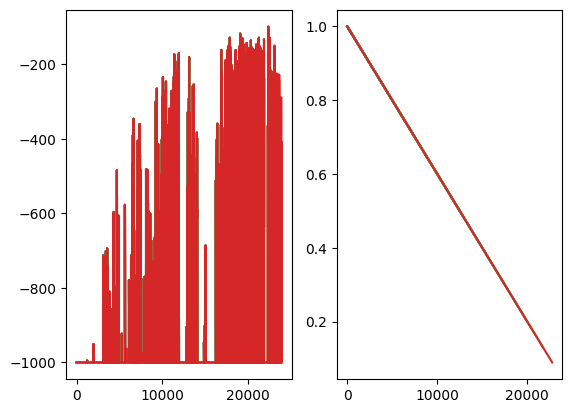

In [ ]:
mountaincar.train(25000, False)

In [ ]:
mountaincar.test(10, "mountaincar_dql_18302.pt")